### Gino's playground

In [1]:
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Custom utils functions
import sys; sys.path.append("./libraries/")
from utils import *

#### Settings

In [2]:
# Relative Paths
RAW_DATA = "../data/raw/"
PROC_DATA = "../data/processed/"

# Flags
process = False

In [3]:
# If process, load raw data and apply matching between datasets 
# NOTE: It may take several minutes
if process:
    # Raw player's datasets
    players = pd.read_csv('https://query.data.world/s/gksm6hx4xzgjaed7tia2uzpafwvyjo?dws=00000')
    ratings22 = pd.read_csv(RAW_DATA + "FIFA22_player_ratings.csv") # FIFA player attributes from 2022
    ratings21 = pd.read_csv(RAW_DATA + "FIFA21_player_ratings.csv") # FIFA player attributes from 2022
    # This appends players from 2021 not present in 2022
    extended = set(ratings21.sofifa_id).difference(set(ratings22.sofifa_id))
    FIFA = pd.concat([ratings22, ratings21[ratings21.sofifa_id.isin(extended)]]).reset_index()

    # Remove uninformative columns
    players.drop(["player_code", "agent_name", "image_url", "url"], axis=1, inplace=True)
    FIFA.drop(["player_url", "club_team_id", "club_position", "club_jersey_number", "club_loaned_from", "club_joined", 
                "nationality_id", "nation_team_id", "nation_jersey_number", "real_face", "player_tags", "player_face_url", 
                "club_logo_url", "club_flag_url", "nation_logo_url", "nation_flag_url"], axis=1, inplace=True)
    
    # Find matches using custom function
    longname_matches = match_players(players, FIFA)
    # Append the extracted FIFA long names
    players["FIFA_long_name"] = longname_matches

    ## Merge players with FIFA attributes
    # Create a unique identifier with long name and year of birth
    players["fifa_id"] = players["FIFA_long_name"] + "-" + pd.to_datetime(players["date_of_birth"]).dt.year.astype(str)
    FIFA["fifa_id"] = FIFA.long_name + "-" + pd.to_datetime(FIFA["dob"]).dt.year.astype(str)
    # Join
    players = players.merge(FIFA, on="fifa_id", how="inner")
    # Drop temp id cols
    players.drop(["name", "fifa_id", "sofifa_id"], axis=1, inplace=True)
    # Save dataset
    players.to_csv(PROC_DATA + "players_wFIFAattributes.csv", index=False)

# Else load processed data
else:
    players = pd.read_csv(PROC_DATA + "players_wFIFAattributes.csv")

# Get valuation data
valuations = pd.read_csv('https://query.data.world/s/y4qg2twfvou4w2ghz6o3evju32g7yn?dws=00000') 
# ... (we can get some more datasets if needed)

# Glance at data
print(players.info())
players.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11159 entries, 0 to 11158
Columns: 112 entries, player_id to gk
dtypes: float64(15), int64(44), object(53)
memory usage: 9.5+ MB
None


,player_id,first_name,last_name,FIFA_long_name,last_season,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
0,3875,Jermain,Defoe,Jermain Colin Defoe,2021,England,London,England,1982-10-07,Centre-Forward,...,43+2,43+2,43+2,43+2,40+2,38+2,38+2,38+2,40+2,18+2
1,4742,Christophe,Lepoint,Christophe Lepoint,2022,Belgium,Brussel,Belgium,1984-10-24,Central Midfield,...,68-1,68-1,68-1,62+2,62+2,67,67,67,62+2,16+2
2,6838,Henok,Goitom,Henok Goitom,2015,Sweden,Solna,Eritrea,1984-09-22,Centre-Forward,...,55+2,55+2,55+2,50+2,48+2,50+2,50+2,50+2,48+2,17+2
3,10003,Wes,Morgan,Wes Morgan,2020,England,Nottingham,Jamaica,1984-01-21,Centre-Back,...,64+2,64+2,64+2,54+2,57+2,73,73,73,57+2,16+2
4,10471,NaN,Luiz Gustavo,Luiz Gustavo Dias,2021,Brazil,Pindamonhangaba,Brazil,1987-07-23,Defensive Midfield,...,75+2,75+2,75+2,71+3,71+3,75+2,75+2,75+2,71+3,17+3


# EDA
TODO

# Survival Analysis

In [4]:
players.loc[(players.last_season < 2021) & (players.current_club_name.isna()) & (players.market_value_in_eur.isna()) & (players.contract_expiration_date.isna())]

,player_id,first_name,last_name,FIFA_long_name,last_season,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
13,26105,Valter,Birsa,Valter Birsa,2019,Jugoslawien (SFR),Sempeter pri Gorici,Slovenia,1986-08-07,Attacking Midfield,...,64+2,64+2,64+2,63+2,60+2,59+2,59+2,59+2,60+2,11+2
32,42086,Timo,Perthel,Timo Perthel,2013,Germany,Kaiserslautern,Germany,1989-02-11,Left-Back,...,64+2,64+2,64+2,65+1,64+2,64+2,64+2,64+2,64+2,15+2
57,56820,Jérémy,Sorbon,Jérémy Sorbon,2018,France,Caen,France,1983-08-05,Centre-Back,...,64+2,64+2,64+2,59+2,60+2,69,69,69,60+2,17+2
73,62240,Maynor,Figueroa,Maynor Alexis Figueroa Róchez,2014,Honduras,Jutiapa,Honduras,1983-05-02,Left-Back,...,66+2,66+2,66+2,63+2,63+2,68,68,68,63+2,17+2
119,101922,Fabio,Pisacane,Fabio Pisacane,2020,Italy,Napoli,Italy,1986-01-28,Centre-Back,...,65+2,65+2,65+2,66+2,67+2,70,70,70,67+2,19+2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10562,326915,Sahan,Kaynak,Dersim Sahan Kaynak,2018,Germany,Paderborn,Germany,1998-10-03,Right Winger,...,41+2,41+2,41+2,47+2,44+2,36+2,36+2,36+2,44+2,11+2
10584,347019,NaN,Júlio César,Júlio César de Freitas Filho,2020,NaN,NaN,Brazil,1995-03-21,Centre-Back,...,63+2,63+2,63+2,59+2,61+2,69+2,69+2,69+2,61+2,17+2
10981,44073,Adrián,González,Adrián González Morales,2017,Spain,Madrid,Spain,1988-05-25,Central Midfield,...,67+1,67+1,67+1,68,67+1,68,68,68,67+1,16+2
11051,491389,Lucas,Chang-Andersen,Lucas Chang-Andersen,2020,NaN,NaN,Denmark,1999-10-06,Goalkeeper,...,23+2,23+2,23+2,20+2,20+2,23+2,23+2,23+2,20+2,50+2


In [8]:
# Detect retired:
## Conditions:
### Last season < 2021
### No current club (NAN)
### No Market value in EUR (NAN)
### No Contract Expiration date (NAN)
players["retired"] = False
players.loc[(players.last_season < 2021) & (players.current_club_name.isna()) & (players.market_value_in_eur.isna()) & (players.contract_expiration_date.isna()), "retired"] = True

players[players.retired]

,player_id,first_name,last_name,FIFA_long_name,last_season,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,...,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,retired
13,26105,Valter,Birsa,Valter Birsa,2019,Jugoslawien (SFR),Sempeter pri Gorici,Slovenia,1986-08-07,Attacking Midfield,...,64+2,64+2,63+2,60+2,59+2,59+2,59+2,60+2,11+2,True
32,42086,Timo,Perthel,Timo Perthel,2013,Germany,Kaiserslautern,Germany,1989-02-11,Left-Back,...,64+2,64+2,65+1,64+2,64+2,64+2,64+2,64+2,15+2,True
57,56820,Jérémy,Sorbon,Jérémy Sorbon,2018,France,Caen,France,1983-08-05,Centre-Back,...,64+2,64+2,59+2,60+2,69,69,69,60+2,17+2,True
73,62240,Maynor,Figueroa,Maynor Alexis Figueroa Róchez,2014,Honduras,Jutiapa,Honduras,1983-05-02,Left-Back,...,66+2,66+2,63+2,63+2,68,68,68,63+2,17+2,True
119,101922,Fabio,Pisacane,Fabio Pisacane,2020,Italy,Napoli,Italy,1986-01-28,Centre-Back,...,65+2,65+2,66+2,67+2,70,70,70,67+2,19+2,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10562,326915,Sahan,Kaynak,Dersim Sahan Kaynak,2018,Germany,Paderborn,Germany,1998-10-03,Right Winger,...,41+2,41+2,47+2,44+2,36+2,36+2,36+2,44+2,11+2,True
10584,347019,NaN,Júlio César,Júlio César de Freitas Filho,2020,NaN,NaN,Brazil,1995-03-21,Centre-Back,...,63+2,63+2,59+2,61+2,69+2,69+2,69+2,61+2,17+2,True
10981,44073,Adrián,González,Adrián González Morales,2017,Spain,Madrid,Spain,1988-05-25,Central Midfield,...,67+1,67+1,68,67+1,68,68,68,67+1,16+2,True
11051,491389,Lucas,Chang-Andersen,Lucas Chang-Andersen,2020,NaN,NaN,Denmark,1999-10-06,Goalkeeper,...,23+2,23+2,20+2,20+2,23+2,23+2,23+2,20+2,50+2,True


In [10]:
# Get the count and amount of retired players by age 
retire_table = players.groupby("age").agg({"age": "count", "retired": "sum"}).rename(columns={"age": "n"})

# Compute h_hat
retire_table["h"] = retire_table.retired / retire_table.n

# Compute S


,n,retired,h
age,,,
16,9,0,0.000000
17,115,0,0.000000
18,344,2,0.005814
19,562,4,0.007117
20,680,7,0.010294
21,757,3,0.003963
22,793,4,0.005044
23,855,4,0.004678
24,843,1,0.001186


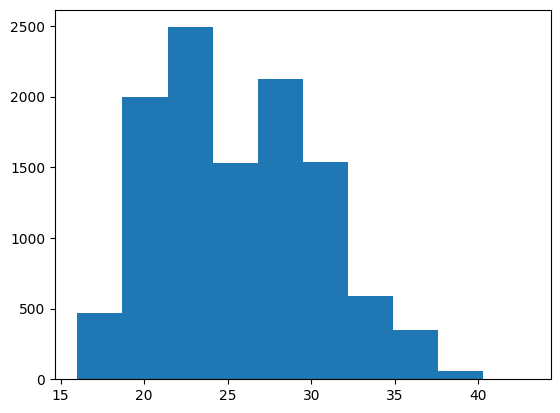

In [43]:
fig, ax = plt.subplots()

ax.hist(players.age);


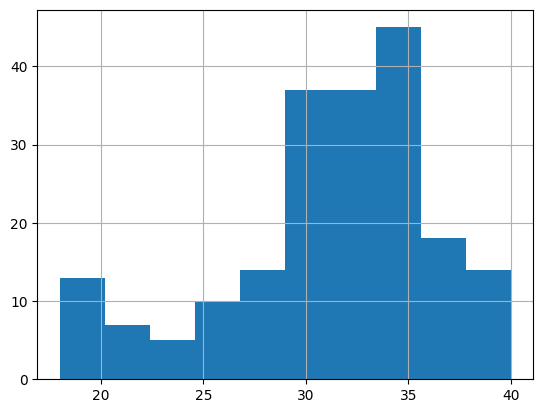

In [15]:
# Detect retired:
## Conditions:
### Last season < 2021
### No current club (NAN)
### No Market value in EUR (NAN)
### No Contract Expiration date (NAN)
players.loc[(players.last_season < 2021) & (players.current_club_name.isna()) & (players.market_value_in_eur.isna()) & (players.contract_expiration_date.isna()), "age"].hist();

In [14]:
players.loc[(players.last_season < 2021) & (players.current_club_name.isna()) & (players.market_value_in_eur.isna()) & (players.contract_expiration_date.isna()), "age"].count()

200

In [10]:
players.loc[6739]

player_id                                       844356
first_name                                       Petro
last_name                                     Velychko
name                                    Petro Velychko
FIFA_long_name                                     NaN
last_season                                       2020
country_of_birth                                   NaN
city_of_birth                                      NaN
country_of_citizenship                         Ukraine
date_of_birth                               2004-08-28
sub_position                               Centre-Back
position                                      Defender
foot                                             right
height_in_cm                                     190.0
market_value_in_eur                                NaN
highest_market_value_in_eur                        NaN
contract_expiration_date                           NaN
current_club_domestic_competition_id              UKR1
current_cl